In [49]:
# ---------------------------------------------------------------------
# Imports
# ---------------------------------------------------------------------
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import pyvista
import imageio
from dolfinx import mesh, fem, la
from ufl import FacetNormal
from ufl import dot, grad, dx, ds, inner
import dolfinx.fem.petsc    
from IPython.display import Image, display

In [50]:
# ---------------------------------------------------------------------
# Define Dependent Variables
# ---------------------------------------------------------------------
initial_condition_spread = 100 #The larger this number the less spread out the initial conditions are
diffusion_coefficient = 0.05
time_step = 5e-4
x_velocity = -4.0
y_velocity = 0.0
final_time = 0.05
output_file_name = "advection_diffusion.gif"

In [51]:
# ---------------------------------------------------------------------
# Define Mesh, trial and test fuction
# ---------------------------------------------------------------------
comm = MPI.COMM_WORLD
mesh_width, mesh_height = 64, 64
domain = mesh.create_unit_square(comm, mesh_width, mesh_height, mesh.CellType.triangle)
V = fem.functionspace(domain, ("Lagrange", 1))

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [52]:
# ---------------------------------------------------------------------
# Definie Initial conditions as a 2d Gaussian
# ---------------------------------------------------------------------
u_prev = fem.Function(V, name="u_prev")
dof_xy = V.tabulate_dof_coordinates()        # (ndofs, 2)
x_vals = dof_xy[:, 0]
y_vals = dof_xy[:, 1]

u_prev.x.array[:] =  np.exp(((x_vals - 0.5)**2 + (y_vals - 0.5)**2) * -initial_condition_spread) #2d Gaussian centerd at (0.5,0.5)
u_prev.x.scatter_forward()

In [53]:
# ---------------------------------------------------------------------
# Define Advection Diffusion Equation
# ---------------------------------------------------------------------

# Physical parameters
D  = dolfinx.fem.Constant(domain, diffusion_coefficient)
dt = dolfinx.fem.Constant(domain, time_step)
v0 = dolfinx.fem.Constant(domain, (x_velocity, y_velocity))

# Outward normal (for the boundary integral)
n = FacetNormal(domain)

# Weak Form of Advection Diffusion equation
a = (u * v + D * dt * dot(grad(u), grad(v)) - dt * dot(v0, grad(u)) * v) * dx

# add the boundary integral into a
a += dt * (dot(v0, n) * u * v) * ds

# Build the right‐hand side form L(v)
L = (u_prev * v) * dx       

# Compil
a_form = dolfinx.fem.form(a)
L_form = dolfinx.fem.form(L)

In [54]:
# ---------------------------------------------------------------------
# Assemble the matrix
# ---------------------------------------------------------------------
A_mat  = dolfinx.fem.petsc.assemble_matrix((a_form), bcs=[]) 
A_mat.assemble()
b_vec  = dolfinx.fem.petsc.assemble_vector((L_form))              

In [55]:
# ---------------------------------------------------------------------
# Define Solver, uses SQR
# ---------------------------------------------------------------------
ksp = PETSc.KSP().create(comm)
ksp.setOperators(A_mat)                    
ksp.setType(PETSc.KSP.Type.CG)
ksp.getPC().setType(PETSc.PC.Type.SOR)

In [56]:
# ---------------------------------------------------------------------
# Solve equation and write screenshots into a gif
# ---------------------------------------------------------------------

# Create plotter for solutions
topo, cells, xyz = dolfinx.plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topo, cells, xyz)
pl = pyvista.Plotter(off_screen=True, window_size=(400,400))
pl.view_isometric()

solution_screenshots = [] 

# Solve the system of equations
u_curr   = fem.Function(V, name="u_curr")
n_steps  = int(final_time / time_step)

for step in range(1, n_steps + 1):
    with b_vec.localForm() as loc:
        loc.set(0.0)

    dolfinx.fem.petsc.assemble_vector(b_vec, L_form)
    b_vec.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode =PETSc.ScatterMode.REVERSE)

    ksp.solve(b_vec, u_curr.x.petsc_vec)      
    u_curr.x.scatter_forward()
    u_prev.x.array[:] = u_curr.x.array
     
    
    if step % 2 == 0:
        pl.clear()
        grid.point_data["u"] = u_curr.x.array
        grid.set_active_scalars("u")
        pl.add_mesh(grid, show_edges=True, clim = [0, 0.5])
       
        mesh_screenshot = pl.screenshot()
        solution_screenshots.append(mesh_screenshot)

    if comm.rank == 0 and step % 10 == 0:
        print(f"step {step:3d}/{n_steps},   t = {step*time_step:6.4f}")

pl.close()

# 8. Write final solution
if comm.rank == 0:
    with imageio.get_writer(output_file_name, mode = "I", fps=10) as writer:
        for fn in solution_screenshots:
            writer.append_data(fn)
    print(output_file_name)



step  10/100,   t = 0.0050
step  20/100,   t = 0.0100
step  30/100,   t = 0.0150
step  40/100,   t = 0.0200
step  50/100,   t = 0.0250
step  60/100,   t = 0.0300
step  70/100,   t = 0.0350
step  80/100,   t = 0.0400
step  90/100,   t = 0.0450
step 100/100,   t = 0.0500
advection_diffusion.gif


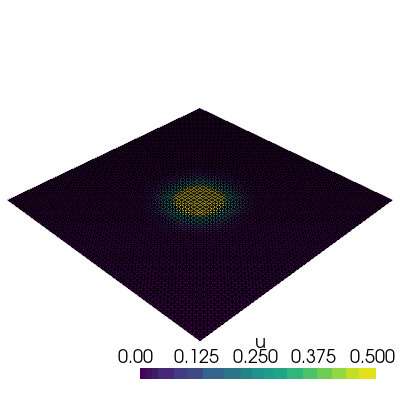

In [ ]:
# ---------------------------------------------------------------------
# Display answer
# --------------------------------------------------------------------
display(Image(filename = output_file_name))
